# Imports and Preparing the data of behavior.tsv and news.tsv #

The following Notebook implements the A-priori and PCY Algorithms for the use with the MIND Dataset
Afterwards we use the frequent item pairs and candidate pairs calculated by the PCY Algorithm to make efficient recommendations 

In [ ]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Create a dictionary mapping 'news_id' to 'title'
news_title_dict = dict(zip(news['news_id'], news['title']))
articles_all = list(news['news_id'])

# Split 'history' into lists of baskets based on ids
# Get rid of NaNs
behaviors.dropna(subset=['history'], inplace=True)
# Group by user and get rid of duplicates in the history
user_histories = []
user_data_for_df = []
for user_id, user_data in behaviors.groupby('user_id'):
    one_history_string = " ".join(user_data['history'])
    splitted_without_duplicates = set(one_history_string.split())
    articles_list_per_user = list(splitted_without_duplicates)
    user_histories.append(articles_list_per_user)
    user_data_for_df.append([user_id, articles_list_per_user])
print(f"Number of histories: {len(user_histories)}")

Number of histories: 698365


# A-Priori Algorithm

In [ ]:
# Pass 1
# Store count of each individual item
articles_count = {}

for history in user_histories:
    for article in history:
        if article in articles_count:
            articles_count[article] += 1
        else:
            articles_count[article] = 1

# Find frequent items
frequent_articles_apriori = {}

# Small Dataset: 50'000 histories -> 1% is 500
# Large Dataset: ~700'000 histories -> 1% is 7000
threshold = 7000

for article, count in articles_count.items():
    if count >= threshold:
        frequent_articles_apriori[article] = count

# Before Pass 2
# Create new array
frequent_singleton_table_apriori = {}
map_value = 1

for article in articles_all:
    if article in frequent_articles_apriori:
        frequent_singleton_table_apriori[article] = map_value
        map_value += 1
    else:
        frequent_singleton_table_apriori[article] = 0
        
# Pass 2
# Store pairs of items (articles) that are both frequent (in frequent_articles)
pairs_of_frequent_articles_apriori = {}

for history in user_histories:
    frequent_items_apriori = []
    for article in history:
        if article in frequent_singleton_table_apriori and frequent_singleton_table_apriori[article] > 0:
            frequent_items_apriori.append(article)

    len_freq_items = len(frequent_items_apriori)
    for i in range(len_freq_items):
        for j in range(i + 1, len_freq_items):
            article1, article2 = sorted((frequent_items_apriori[i], frequent_items_apriori[j]))
            pair = (article1, article2)

            if pair in pairs_of_frequent_articles_apriori:
                pairs_of_frequent_articles_apriori[pair] += 1
            else:
                pairs_of_frequent_articles_apriori[pair] = 1

min_support = 7000
frequent_pairs_apriori = {}
for pair, count in pairs_of_frequent_articles_apriori.items():
    if count >= min_support:
        frequent_pairs_apriori[pair] = count

print(f"Number of frequent items: {len(frequent_articles_apriori)}")
print(f"Number of frequent pairs: {len(frequent_pairs_apriori)}")         
    
# 3 set
triplets_of_frequent_articles = {}
frequent_triplets = {}

for history in user_histories:
    frequent_items_apriori = []
    for article in history:
        if frequent_singleton_table_apriori.get(article, 0) > 0:
            frequent_items_apriori.append(article)

    len_freq_items = len(frequent_items_apriori)
    for i in range(len_freq_items):
        for j in range(i + 1, len_freq_items):
            for k in range(j + 1, len_freq_items):
                article1, article2, article3 = sorted((frequent_items_apriori[i], frequent_items_apriori[j], frequent_items_apriori[k]))
                triplet = (article1, article2, article3)

                if article1 in frequent_singleton_table_apriori and article2 in frequent_singleton_table_apriori and article3 in frequent_singleton_table_apriori:
                    if triplet in triplets_of_frequent_articles:
                        triplets_of_frequent_articles[triplet] += 1
                    else:
                        triplets_of_frequent_articles[triplet] = 1

min_support = 1000
for triplet, count in triplets_of_frequent_articles.items():
    if count >= min_support:
        frequent_triplets[triplet] = count

print(f"Number of frequent triplets: {len(frequent_triplets)}") 

Number of frequent items: 282
Number of frequent pairs: 16
Number of frequent triplets: 429


# PC-Y Algorithm

In [13]:
# Pass 1 of the PC-Y algorithm: Count individual items and hash pairs
# Define parameters
min_support = 7000
hash_table_size = 500000  # Size of the hash table

# Initialize counters
item_count = defaultdict(int)
hash_table = [0] * hash_table_size

# Count individual items and hash pairs, skipping self-pairs
for history in user_histories:
    for article in history:
        item_count[article] += 1

    # Generate item pairs using combinations and skip self-pairs
    for pair in combinations(history, 2):
        # Skip self-pairs
        if pair[0] == pair[1]:
            continue

        hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
        hash_table[hash_index] += 1

# Create a bitmap based on the minimum support threshold
bitmap = [1 if count >= min_support else 0 for count in hash_table]

# Filter out infrequent items
frequent_articles_pcy = {article for article, count in item_count.items() if count >= min_support}
print(f"Number of frequent items: {len(frequent_articles_pcy)}")

#Pass 2
candidate_pairs = defaultdict(int)

for history in user_histories:
    # Filter to include only frequent items
    filtered_basket = [article for article in history if article in frequent_articles_pcy]

    for pair in combinations(filtered_basket, 2):
        if pair[0] != pair[1] and pair[0] in frequent_articles_pcy and pair[1] in frequent_articles_pcy:
            article1, article2 = sorted((pair[0], pair[1])) 
            hash_index = (hash(article1) + hash(article2)) % hash_table_size
            if bitmap[hash_index]:
                candidate_pairs[(article1, article2)] += 1

#identify frequent pairs
frequent_pairs_pcy = {pair: count for pair, count in candidate_pairs.items() if count >= min_support}
print(f"Number of frequent pairs: {len(frequent_pairs_pcy)}")
print(f"Number of candidate pairs: {len(candidate_pairs)}")

Number of frequent items: 282
Number of frequent pairs: 16
Number of candidate pairs: 34


# Recommender System based on PCY Baskets

Recommendations leveraging the capabilities of the PCY algorithm.
First we check if the input article based on which the user is supposed to get 10 recommendations, is a frequent item.
If yes, first the user gets recommended articles based on the Frequent pairs the article is part of, if it is less than 10 he gets recommeded articles based on the candidate pairs. In case that is still not enough to make 10 recommendations, the user also gets recommended the most popular articles from the same category.
When the input article itself is not part of the frequent items, the recommendation system, recommends based on the most frequent articles from the same category. 

In [14]:
def recommend_articles(input_article_id, num_recommendations=10):
    recommendations = []
    article_titles = []
    recommendation_reasons = []  # List to store reasons for each recommendation
    recommended_articles_set = set()  # To avoid duplicate recommendations

    # Check if the input article exists
    if input_article_id not in news['news_id'].values:
        print(f"Article ID {input_article_id} does not exist.")
        return []
    

    # Initialize variables
    total_recommendations = 0

    # Step 1: Recommend based on frequent pairs
    pairs_involving_input = {pair: count for pair, count in frequent_pairs_pcy.items() if input_article_id in pair}

    if pairs_involving_input:
        # Get articles paired with the input article
        paired_articles = {}
        for pair, count in pairs_involving_input.items():
            other_article = pair[0] if pair[1] == input_article_id else pair[1]
            if other_article != input_article_id:
                paired_articles[other_article] = count
        # Sort articles based on co-occurrence count
        sorted_articles = sorted(paired_articles.items(), key=lambda x: x[1], reverse=True)
        # Add recommendations
        for article_id, count in sorted_articles:
            if total_recommendations < num_recommendations and article_id not in recommended_articles_set:
                recommendations.append(article_id)
                recommendation_reasons.append("Recommended based on frequent pair with input article.")
                recommended_articles_set.add(article_id)
                total_recommendations += 1
            if total_recommendations >= num_recommendations:
                break

    # Step 2: Recommend based on candidate pairs
    if total_recommendations < num_recommendations:
        candidate_pairs_involving_input = {pair: count for pair, count in candidate_pairs.items() if input_article_id in pair}
        if candidate_pairs_involving_input:
            # Get articles paired with the input article
            candidate_articles = {}
            for pair, count in candidate_pairs_involving_input.items():
                other_article = pair[0] if pair[1] == input_article_id else pair[1]
                if other_article != input_article_id and other_article not in recommended_articles_set:
                    candidate_articles[other_article] = count
            # Sort articles based on co-occurrence count
            sorted_articles = sorted(candidate_articles.items(), key=lambda x: x[1], reverse=True)
            # Add recommendations
            for article_id, count in sorted_articles:
                if total_recommendations < num_recommendations and article_id not in recommended_articles_set:
                    recommendations.append(article_id)
                    recommendation_reasons.append("Recommended based on candidate pair with input article.")
                    recommended_articles_set.add(article_id)
                    total_recommendations += 1
                if total_recommendations >= num_recommendations:
                    break

    # Step 3: Recommend based on article category
    if total_recommendations < num_recommendations:
        # Get the category of the input article
        article_category = news.loc[news['news_id'] == input_article_id, 'category'].values[0]
        # Filter articles in the same category
        articles_in_category = news[news['category'] == article_category]['news_id'].tolist()
        # Get frequency counts of articles in the same category
        category_article_counts = {article: item_count.get(article, 0) for article in articles_in_category if article != input_article_id and article not in recommended_articles_set}
        # Sort articles based on frequency count
        sorted_articles = sorted(category_article_counts.items(), key=lambda x: x[1], reverse=True)
        # Add recommendations
        for article_id, count in sorted_articles:
            if total_recommendations < num_recommendations:
                recommendations.append(article_id)
                recommendation_reasons.append("Recommended as a frequent article in the same category.")
                recommended_articles_set.add(article_id)
                total_recommendations += 1
            if total_recommendations >= num_recommendations:
                break

    # Retrieve titles for the recommended articles
    for article_id in recommendations:
        title = news_title_dict.get(article_id, "Title not found")
        article_titles.append((article_id, title))

    # Output the recommendations with reasons
    print("\nRecommended Articles:")
    for idx, (article_id, title) in enumerate(article_titles):
        reason = recommendation_reasons[idx]
        print(f"Article ID: {article_id}, Title: {title}, Reason: {reason}")

    return article_titles

input_article = 'N71977'
recommended_articles = recommend_articles(input_article)




Recommended Articles:
Article ID: N104737, Title: Kevin Spacey Won't Be Charged in Sexual Assault Case After Accuser Dies, Reason: Recommended based on frequent pair with input article.
Article ID: N91597, Title: Heidi Klum's 2019 Halloween Costume Transformation Is Mind-Blowing   But, Like, What Is It?, Reason: Recommended based on candidate pair with input article.
Article ID: N72571, Title: Former NFL lineman Justin Bannan arrested for attempted murder, Reason: Recommended based on candidate pair with input article.
Article ID: N85484, Title: NFL world reacts to officials handing Packers win over Lions, Reason: Recommended as a frequent article in the same category.
Article ID: N112324, Title: Boxer Patrick Day dies after suffering traumatic brain injury in super welterweight fight, Reason: Recommended as a frequent article in the same category.
Article ID: N42718, Title: What Tom Brady, Lamar Jackson Told Each Other After Patriots-Ravens, Reason: Recommended as a frequent article 

# Visualizations for A-Priori and PC-Y

The following visualizations are based on the small dataset and give a first overview over the algorithms and the results.

In [15]:
# Extract top 10 pairs from both algorithms
pairs_list_apriori = list(frequent_pairs_apriori.items())
sorted_pairs_apriori = sorted(pairs_list_apriori, key=lambda x: x[1], reverse=True)
top_10_apriori = sorted_pairs_apriori[:10]

pairs_list_pcy = list(frequent_pairs_pcy.items())
sorted_pairs_pcy = sorted(pairs_list_pcy, key=lambda x: x[1], reverse=True)
top_10_pcy = sorted_pairs_pcy[:10]

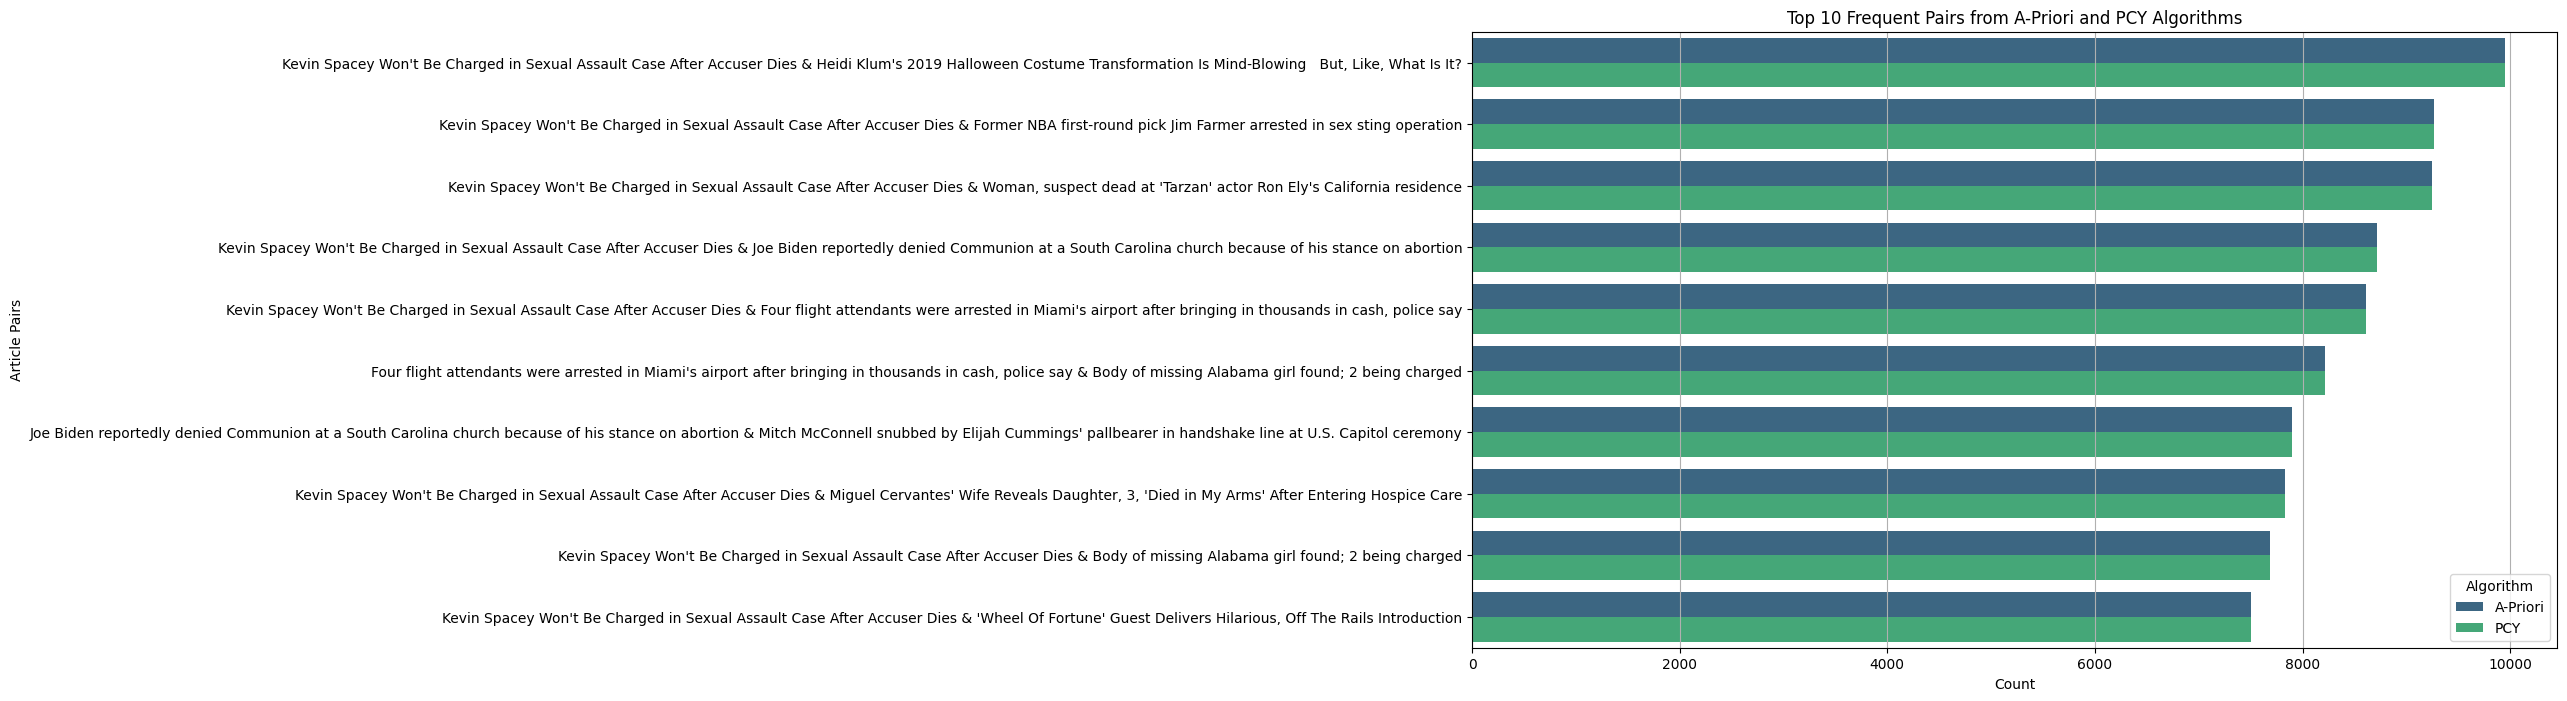

In [ ]:
# Prepare data for plotting
apriori_pairs_10 = []
apriori_counts_10 = []
for pair, count in top_10_apriori:
    title = str(news_title_dict[pair[0]]) + " & " + str(news_title_dict[pair[1]])
    apriori_pairs_10.append(title)
    apriori_counts_10.append(count)

pcy_pairs_10 = []
pcy_counts_10 = []
for pair, count in top_10_pcy:
    title = str(news_title_dict[pair[0]]) + " & " + str(news_title_dict[pair[1]])
    pcy_pairs_10.append(title)
    pcy_counts_10.append(count)

# Dataframe for easier vizualisation
plot_data = pd.DataFrame({
    'Pair': apriori_pairs_10 + pcy_pairs_10,
    'Count': apriori_counts_10 + pcy_counts_10,
    'Algorithm': ['A-Priori'] * 10 + ['PCY'] * 10})

plt.figure(figsize=(14, 8))
sns.barplot(data=plot_data, x='Count', y='Pair', hue='Algorithm', palette='viridis')

plt.title('Top 10 Frequent Pairs from A-Priori and PCY Algorithms')
plt.xlabel('Count')
plt.ylabel('Article Pairs')
plt.legend(title='Algorithm')
plt.grid(axis='x')
plt.show()

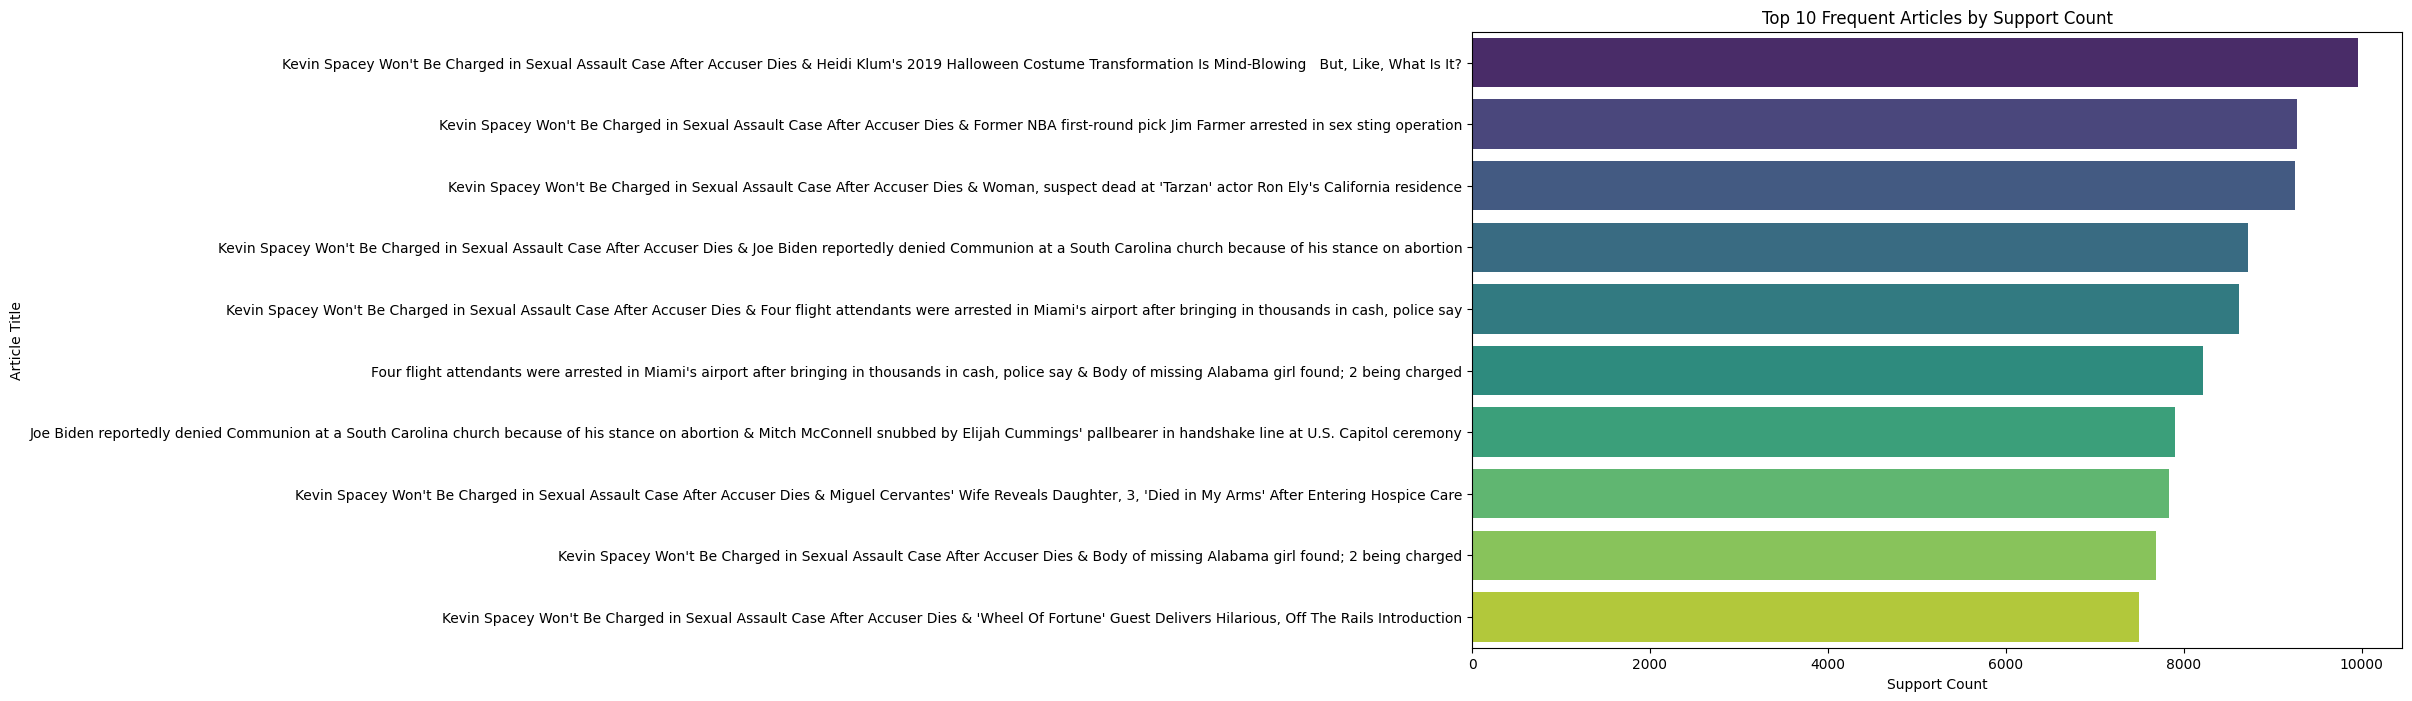

In [ ]:
# Another visualization type

if top_10_apriori == top_10_pcy:

    apriori_pairs = []
    apriori_counts = []
    for pair, count in top_10_apriori:
        title = str(news_title_dict[pair[0]]) + " & " + str(news_title_dict[pair[1]])
        apriori_pairs.append(title)
        apriori_counts.append(count)

    plot_data = pd.DataFrame({
        'Title': apriori_pairs,
        'Count': apriori_counts})

    plt.figure(figsize=(12, 8))
    sns.barplot(data=plot_data, x='Count', y='Title', hue='Title', dodge=False, legend=False, palette='viridis')

    plt.title("Top 10 Frequent Articles by Support Count")
    plt.xlabel("Support Count")
    plt.ylabel("Article Title")
    plt.show()

else:
    "Different Top 10 for A-priori and PC-Y"

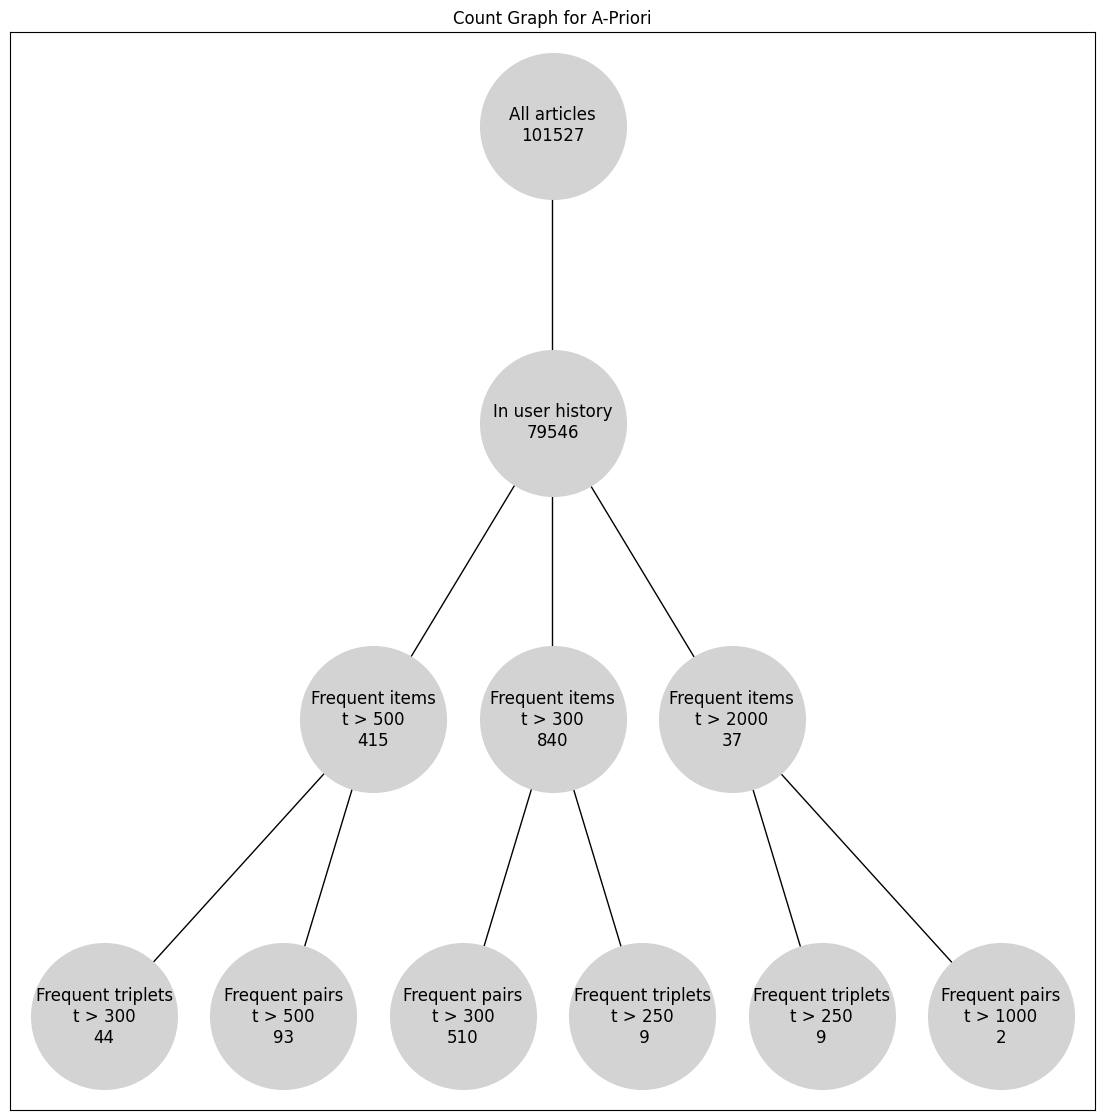

In [ ]:
# Create nodes
A = "All articles\n" + str(len(articles_all))
B = "In user history\n" + str(len(articles_count))
C = "Frequent items\nt > 2000\n" + str(37)
D = "Frequent triplets\nt > 250\n" + str(9) #t > 2000
E = "Frequent pairs\nt > 1000\n" + str(2)   #t > 2000
F = "Frequent items\nt > 500\n" + str(415)
H = "Frequent triplets\nt > 300\n" + str(44) #t > 500
I = "Frequent pairs\nt > 500\n" + str(93)    #t > 500
J = "Frequent items\nt > 300\n" + str(840)
K = "Frequent triplets\nt > 250\n " + str(9) #t > 300
L = "Frequent pairs\nt > 300\n" + str(510)  #t > 300

# Connect nodes
G = nx.DiGraph()
G.add_edges_from(
    [(A, B), 
     (B, C),
     (C, D),
     (C, E),
     (B, F),
     (F, H),
     (F, I),
     (B, J),
     (J, K),
     (J, L)
      ])

# Create level for top-down view
G.nodes[A]["subset"] = 0
G.nodes[B]["subset"] = 1
G.nodes[C]["subset"] = 2
G.nodes[D]["subset"] = 3
G.nodes[E]["subset"] = 3
G.nodes[F]["subset"] = 2
G.nodes[H]["subset"] = 3
G.nodes[I]["subset"] = 3
G.nodes[J]["subset"] = 2
G.nodes[K]["subset"] = 3
G.nodes[L]["subset"] = 3

pos = nx.multipartite_layout(G, subset_key="subset")

# For nicer visualization in the report: rearrange nodes
pos[E], pos[I], pos[K], pos[D] = pos[K], pos[E], pos[D], pos[I]

pos = {node: (y, -x) for node, (x, y) in pos.items()}

plt.figure(figsize=(14, 14))

nx.draw_networkx_nodes(G, pos, node_size=11000, node_color="lightgray")
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)

plt.title("Count Graph for A-Priori")
plt.show()

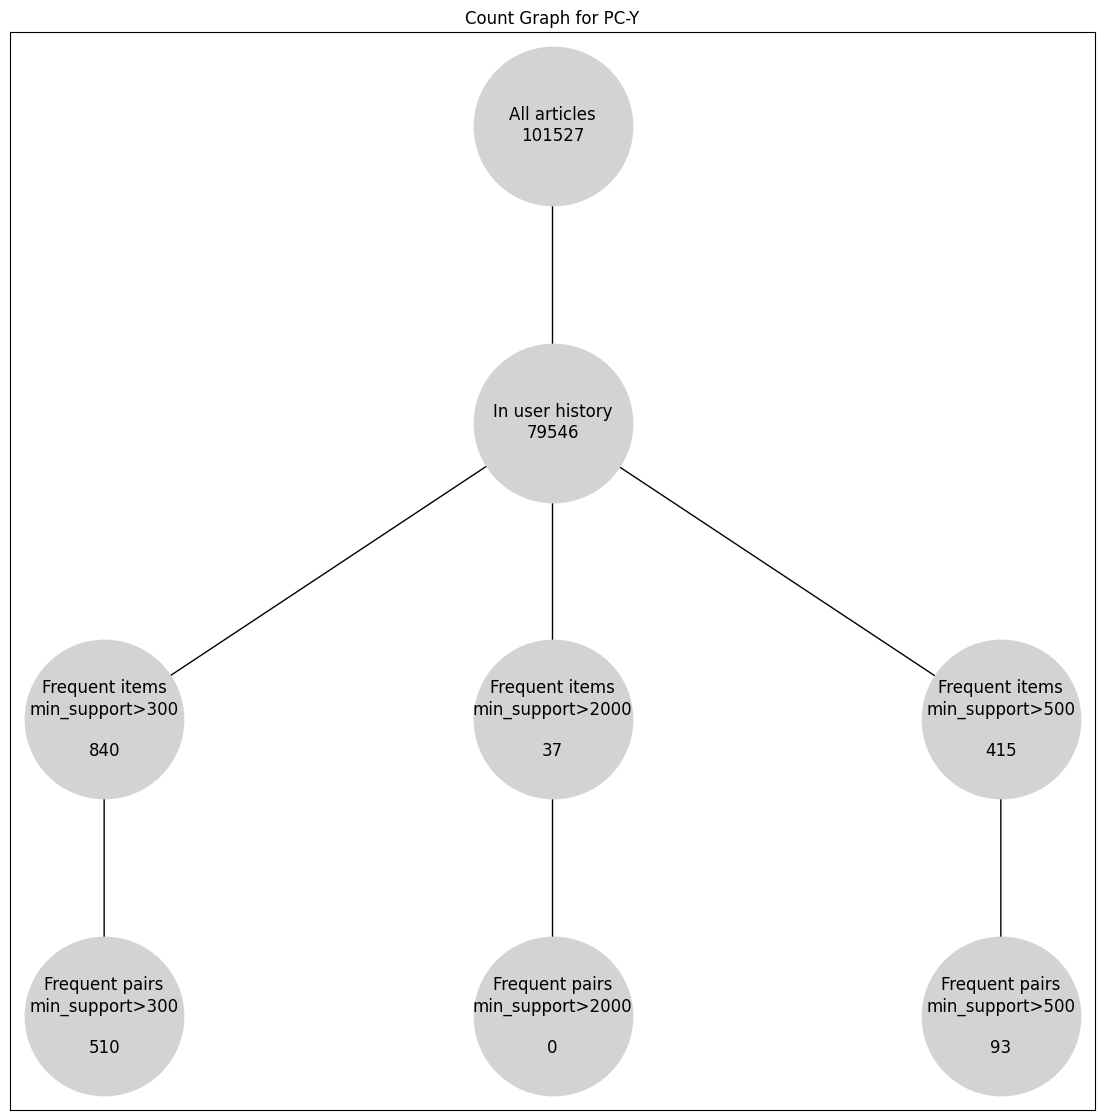

In [25]:
# Create nodes
A = "All articles\n" + str(len(articles_all))
B = "In user history\n" + str(len(articles_count))
C = "Frequent items\nmin_support>2000\n\n" + str(37)
D = "Frequent pairs\nmin_support>2000\n\n" + str(0)
E = "Frequent items\nmin_support>300\n\n" + str(840)
F = "Frequent pairs\nmin_support>300\n\n" + str(510)
H = "Frequent items\nmin_support>500\n\n" + str(415)
I = "Frequent pairs\nmin_support>500\n\n" + str(93)

# Connect nodes
G = nx.DiGraph()
G.add_edges_from(
    [(A, B), 
     (B, C),
     (C, D),
     (B, E),
     (E, F),
     (B, H),
     (H, I)
      ])

# Create level for top-down view
G.nodes[A]["subset"] = 0
G.nodes[B]["subset"] = 1
G.nodes[C]["subset"] = 2
G.nodes[D]["subset"] = 3
G.nodes[E]["subset"] = 2
G.nodes[F]["subset"] = 3
G.nodes[H]["subset"] = 2
G.nodes[I]["subset"] = 3

pos = nx.multipartite_layout(G, subset_key="subset")

# For nicer visualization in the report: rearrange nodes
pos[F], pos[D], pos[I] = pos[I], pos[F], pos[D]

pos = {node: (y, -x) for node, (x, y) in pos.items()}

plt.figure(figsize=(14, 14))

nx.draw_networkx_nodes(G, pos, node_size=13000, node_color="lightgray")
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)

plt.title("Count Graph for PC-Y")
plt.show()